# Learning python non-stop


In [ ]:
path1 = "zort"
path2 = "tırt"
path3 = "anno"

complete = os.path.join(path1,path2,path3)


# for test in os.listdir('/content/fruit-images-for-object-detection/train_zip/train'):
#   if test.split('.')[1] == 'xml':
#     print(test)

what = ((1,2),(3,5))
what[0]

# Apple Detection

[Basics of Yolo v5 - Balloon Detection](https://www.kaggle.com/code/vbookshelf/basics-of-yolo-v5-balloon-detection/notebook)

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from google.colab.patches import cv2_imshow
import os

In [2]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection")
# original data base https://www.kaggle.com/datasets/andrewmvd/road-sign-detection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: grkmkcgl
Your Kaggle Key: ··········


100%|██████████| 28.4M/28.4M [00:03<00:00, 8.90MB/s]


# Convert XML to Yolo annotation

In [3]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5 
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 14799, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 14799 (delta 75), reused 92 (delta 49), pack-reused 14669
Receiving objects: 100% (14799/14799), 13.55 MiB | 10.12 MiB/s, done.
Resolving deltas: 100% (10214/10214), done.
/content/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 42.3 MB/s 


In [4]:
from os import path

if path.exists('/content/labels') == False:
  os.mkdir('/content/labels')

In [5]:
import os
import xml.etree.ElementTree as ET

def convert_box(size, box):
    dw, dh = 1. / size[0], 1. / size[1]
    x, y, w, h = (box[0] + box[1]) / 2.0 - 1, (box[2] + box[3]) / 2.0 - 1, box[1] - box[0], box[3] - box[2]
    return x * dw, y * dh, w * dw, h * dh

def convert_voc_to_yolo():
    for anno in os.listdir('/content/fruit-images-for-object-detection/train_zip/train'):
      if anno.split('.')[1] == 'xml':
          file_name = anno.split('.')[0]
          out_file = open(f'/content/labels/{file_name}.txt', 'w')

          tree_path = os.path.join('/content/fruit-images-for-object-detection/train_zip/train', anno)
          print(tree_path)
          tree = ET.parse(tree_path)
          root = tree.getroot()
          size = root.find('size')        
          w = int(size.find('width').text)
          h = int(size.find('height').text)

          names = ['apple', 'banana', 'orange']

          for obj in root.iter('object'):
              cls = obj.find('name').text
              if cls in names and int(obj.find('difficult').text) != 1:
                  xmlbox = obj.find('bndbox')
                  if (w == 0) or (h == 0): pass
                  else:
                    bb = convert_box((w, h), [float(xmlbox.find(x).text) for x in ('xmin', 'xmax', 'ymin', 'ymax')])
                  cls_id = names.index(cls)  # class id
                  out_file.write(" ".join([str(a) for a in (cls_id, *bb)]) + '\n')
                    

In [6]:
convert_voc_to_yolo()

/content/fruit-images-for-object-detection/train_zip/train/banana_29.xml
/content/fruit-images-for-object-detection/train_zip/train/orange_69.xml
/content/fruit-images-for-object-detection/train_zip/train/mixed_9.xml
/content/fruit-images-for-object-detection/train_zip/train/orange_61.xml
/content/fruit-images-for-object-detection/train_zip/train/orange_29.xml
/content/fruit-images-for-object-detection/train_zip/train/orange_8.xml
/content/fruit-images-for-object-detection/train_zip/train/apple_56.xml
/content/fruit-images-for-object-detection/train_zip/train/banana_14.xml
/content/fruit-images-for-object-detection/train_zip/train/apple_62.xml
/content/fruit-images-for-object-detection/train_zip/train/orange_12.xml
/content/fruit-images-for-object-detection/train_zip/train/banana_55.xml
/content/fruit-images-for-object-detection/train_zip/train/apple_61.xml
/content/fruit-images-for-object-detection/train_zip/train/banana_20.xml
/content/fruit-images-for-object-detection/train_zip/trai

In [7]:
!mv /content/labels /content/fruit-images-for-object-detection/train_zip

os.rename("/content/fruit-images-for-object-detection/train_zip/train", "/content/fruit-images-for-object-detection/train_zip/images")

In [14]:
!cp /content/yolov5/data/VOC.yaml /content/yolov5/customVOC.yaml

# after this code go to /content/yolov5/VOC.yaml and edit file
# path: /content/fruit-images-for-object-detection/train_zip
# train: # train images (relative to 'path')  16551 images
#   - images
# val: # val images (relative to 'path')  4952 images
#   - images


# # Classes
# names:
#   0: apple
#   1: banana
#   2: orange

# Train model

In [9]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2
import itertools
import os 

In [15]:
%cd /content/yolov5
!python train.py --img 320 --batch 16 --epochs 100 --data customVOC.yaml --weights yolov5s.pt --workers 4

/content/yolov5
train: weights=yolov5s.pt, cfg=, data=customVOC.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=4, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-239-gf33718f Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hs

In [24]:
# check exp file and insert path below:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/yolov5/runs/train/exp/weights/best.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-11-12 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [18]:
def xml_file_deleter(path):
  for img in os.listdir(path):
    if img.split('.')[1] == 'xml':
      img = os.path.join(path, img)
      os.remove(img)
      print("deleted file", img)    
    else: 
      pass

In [19]:
# delete xml files in test folder:
img_path = '/content/fruit-images-for-object-detection/test_zip/test'
xml_file_deleter(img_path)

deleted file /content/fruit-images-for-object-detection/test_zip/test/orange_86.xml
deleted file /content/fruit-images-for-object-detection/test_zip/test/banana_81.xml
deleted file /content/fruit-images-for-object-detection/test_zip/test/banana_89.xml
deleted file /content/fruit-images-for-object-detection/test_zip/test/apple_86.xml
deleted file /content/fruit-images-for-object-detection/test_zip/test/banana_83.xml
deleted file /content/fruit-images-for-object-detection/test_zip/test/apple_77.xml
deleted file /content/fruit-images-for-object-detection/test_zip/test/orange_79.xml
deleted file /content/fruit-images-for-object-detection/test_zip/test/apple_88.xml
deleted file /content/fruit-images-for-object-detection/test_zip/test/mixed_23.xml
deleted file /content/fruit-images-for-object-detection/test_zip/test/banana_82.xml
deleted file /content/fruit-images-for-object-detection/test_zip/test/apple_95.xml
deleted file /content/fruit-images-for-object-detection/test_zip/test/banana_91.x

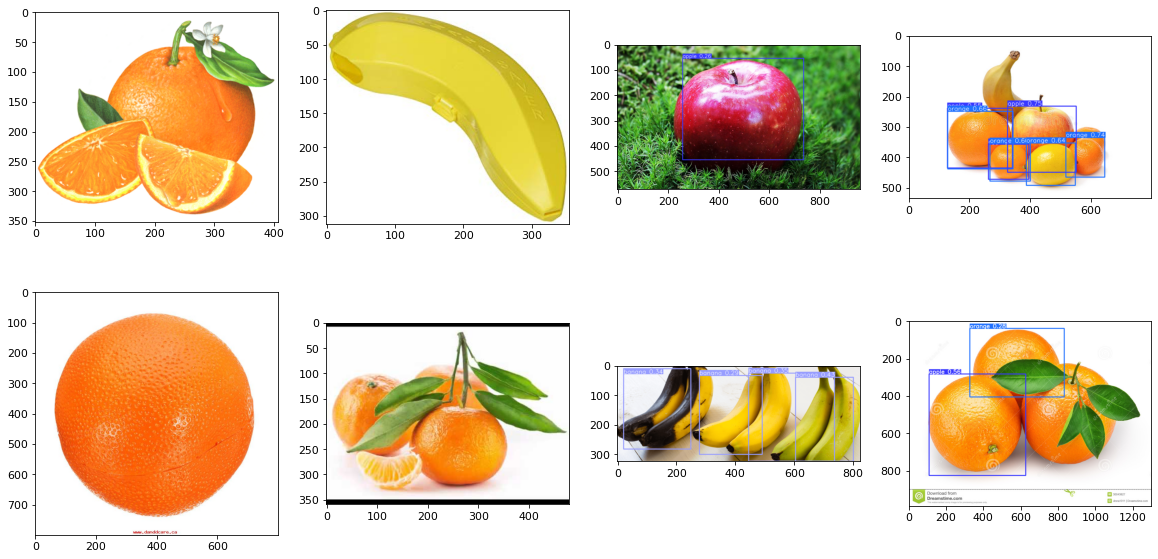

In [ ]:
fig, ax = plt.subplots(2,4, figsize=(20,10))
imgs = os.listdir('/content/fruit-images-for-object-detection/test_zip/test')



for idx in itertools.product(range(2),range(4)): 
    imgname = np.random.choice(imgs)
    img = cv2.imread(f'/content/fruit-images-for-object-detection/test_zip/test/{imgname}')
    results = model(img)
    ax[idx[0],idx[1]].imshow(cv2.cvtColor(np.squeeze(results.render()), cv2.COLOR_BGR2RGB))


# DATASETS GIVEN BOUNDING BOXES ARE SEEMS SLIGTLY WRONG(?)

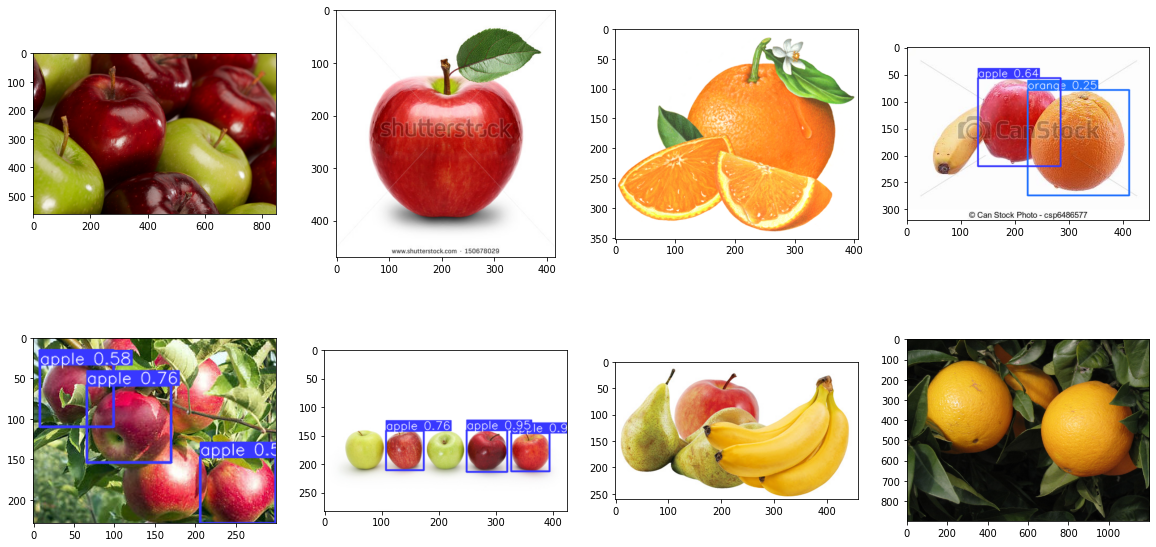

In [28]:
fig, ax = plt.subplots(2,4, figsize=(20,10))
imgs = os.listdir('/content/fruit-images-for-object-detection/test_zip/test')



for idx in itertools.product(range(2),range(4)): 
    imgname = np.random.choice(imgs)
    img = cv2.imread(f'/content/fruit-images-for-object-detection/test_zip/test/{imgname}')
    results = model(img)
    ax[idx[0],idx[1]].imshow(cv2.cvtColor(np.squeeze(results.render()), cv2.COLOR_BGR2RGB))